## Notebook #7 goal

This notebook modifies the main model to integrate the NHPP and the variable stay code together and performs a test run, and "new stuff" :
- adds send_to_hotel code (done)
- incorporates Srees viz
- parameterizes multiple runs (done)
- updates the mental case to beta distribution

#### Very basic shelter model

This simpy model is Inspired by car wash example https://simpy.readthedocs.io/en/latest/examples/carwash.html

The parameters in this model are:
- the client is only 1 person 
    - *this need to make it random from 1-6)*
- the stay period of client is random, and between 7 days to 365
    - *this needs to be made into a distribution (or combination of distribution) based on any one of the four cases discussed [here](https://github.com/sim-team-z/learning-simpy/blob/main/README.md)*
- the number of beds in shelter are 35
- the clients arrive at the shelter seeking refuge every 7 days.
    - *this needs to be made variable, perhaps picking an RV from a poisson distribution*


This model also turn away clients when at capacity, and keeps count of the number.

In [274]:
import math
import numpy as np
import pandas as pd
import random
from scipy.stats import poisson
from scipy.stats import beta
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import simpy
from datetime import datetime
import csv

In [581]:
#GLOBAL VARIABLES

RANDOM_SEED = 42 # not used
NUM_BEDS = 15  # Number of beds in the shelter
MAX_FAMILY_SIZE = 6 # maximum # of people in the client's family (mom and children)
CASE_DISTRIBUTION = [0.25, 0.25, 0.25, 0.25] # ratio of clients showing up [CAPABLE, CULTURAL CHALLENGES, MENTAL CHALLENGES, SKILLS GAP]
POISSON_ARRIVAL_JAN_AUG =  10 #a family every 10 days
POISSON_ARRIVAL_SEP_DEC = 5 #  a family every 5 days
PROB_THAT_CLIENTS_LIFE_IS_THREATENED = 0.10 #these clients need to be sent to undisclosed hotel
SIM_TIME = 365*3    # Simulation time in days
NUMBER_OF_RUNS=3 # the number of simulation iterations we wish to run

class ShelterData(object):
    # an instanc of this class allows for a  persisted data structure across multiple simulation runs
    # where all the details of the simulation can be captured.
    def __init__(self):
        self.data_table = pd.DataFrame({
            'run_number' : [],
            'day': [],
            'month' : [],
            'sent_to_hotel' : [],
            'ppl_turned_away': [],
            'shelter_capacity_left': [],
            'client_case1': [],
            'client_case2': [],
            'client_case3': [],
            'client_case4': []
        })
            
    def append_shelter_data(self,data_array):
        df2 = pd.DataFrame({
        'run_number' : [data_array[0]],
        'day': [data_array[1]],
        'month' : [data_array[2]],
        'sent_to_hotel' : [data_array[3]],
        'ppl_turned_away': [data_array[4]],
        'shelter_capacity_left': [data_array[5]],
        'client_case1': [data_array[6]],
        'client_case2': [data_array[7]],
        'client_case3': [data_array[8]],
        'client_case4': [data_array[9]]
                            })
        return pd.concat([self.data_table,df2])


    
class Shelter(object):
    """A shelter has a limited number of beds (``NUM_BEDS``) to
    host clients.

    Clients have to request one of the beds. When they got one, they
    can start their stay (which takes ``staytime`` minutes).

    """
    referred_clients = 0
    day_of_year = 1
    
    def __init__(self, env, num_beds):
        self.env = env
        self.shelter = simpy.Resource(env, num_beds)
        print('~~SIMULATION STARTUP~~ Shelter has {} beds available'.format(NUM_BEDS - self.shelter.count))
        #self.staytime = staytime
        self.referred_clients = 0
        self.sent_to_hotel = 0

    def get_count_of_referred_clients():
        return self.referred_clients
    
    def increment_count_of_referred_clients():
        self.referred_clients += 1
    
    def stay2(self, client_name, family_size, case):
        #simulates duration of stay for client (and family, if applicable)
        #based on her case (CAPABLE=1, CULTURAL=2, MENTAL=3, SKILLS=4)
        
        if case == 1 : # Capable and quickly back on their feet
            stay_duration = random.randint(7, 2*30)
        elif case == 2: #Language and cultural barrier
            stay_duration = random.randint(9*30, 12*30)
        elif case == 3: #Mental barrier
            stay_duration = random.randint(4*30, 9*30) # TODO this is a long tailed distribution, not uniform. check README.md.
            #need to change
        elif case == 4:
            stay_duration = random.randint(2*30, 6*30)
        
        return stay_duration
        
    
def month(day_num):
    #receives simulation day number and returns the month. 
    #example: receives 32 returns 02 (as the 32nd day of run is feb 1st)
    day_num= day_num % 365 
    if day_num == 0:
        day_num = 1
    year = "2022"
    # converting to date
    month = datetime.strptime(year + "-" + str(day_num), "%Y-%j").strftime("%m")
    return month
  

        

def number_of_days_next_client_turns_up(current_day):
    #if the day is within first 8 months (Jan - Aug), the rate of clients coming in is slower 
    # than if its between 9-12th (Sept-Dec) months.
    # there should be an option in simpy to find the day of the simulation too
    # 242 days === January 1, 2022 - August 31, 2022
    if current_day < 242:
        return poisson.rvs(POISSON_ARRIVAL_JAN_AUG)
    else:
        return poisson.rvs(POISSON_ARRIVAL_SEP_DEC)
            
def client_family_size():
    return random.randint(1, MAX_FAMILY_SIZE)

def client_case_type():
    caseList = [1,2,3,4]
    return random.choices(caseList, weights=CASE_DISTRIBUTION, k=1)[0]
    

def client(env, client_name, family_size, case_type, shelter_object, shelter_data_object, run_number):
    # The client process (each client has a client_name) arrives potentially 
    # with family (family_size) with a condition (case_type) at the shelter 
    # and requests bed(s).
    if (bernoulli.rvs(PROB_THAT_CLIENTS_LIFE_IS_THREATENED, size=1)[0] == 1):
        #this clients life is under threat, and needs to be sent to a hotel
        shelter_object.sent_to_hotel += family_size
        print("(day {})\t[client] Shelter has sent {} clients (including their family members) \
              with life-threatening situations to undisclosed hotels."
              .format(env.now, shelter_object.sent_to_hotel))
        
        # event! shelter just sent people to hotel, write to the pandas data_table:
        #first , prepare case_array, (all zeros here)
        case_array = [0,0,0,0]
        data_array = [run_number,env.now+1,month(env.now+1),
                      shelter_object.sent_to_hotel,
                      shelter_object.referred_clients,
                      NUM_BEDS - shelter_object.shelter.count]

        #finally, append both data_array and case_array and shove that into the data_table.
        shelter_data_object.data_table = shelter_data_object.append_shelter_data(np.append(data_array,case_array))
        #pd.set_option('expand_frame_repr', False)
        #print(shelter_data_object.data_table)
        
    else:
        #this code block checks if there is room in shelter or not and acts accordingly:
        if (
            (NUM_BEDS - shelter_object.shelter.count == 0) or 
            (NUM_BEDS - shelter_object.shelter.count < family_size)):
            print("(day {})\t[client] !!!!SHELTER AT CAPACITY. only {} available beds. Referring out {} family of {} "
                  .format(env.now,
                          NUM_BEDS - shelter_object.shelter.count,
                          client_name,
                          family_size))

            shelter_object.referred_clients += family_size    
            #referred_clients_count = shelter_object.referred_clients
            print("(day {})\t[client] Shelter has unfortunately turned {} clients (including their family members) away thus far."
                  .format(env.now, shelter_object.referred_clients))

            # event! shelter just turned away people, write to the pandas data_table:
            #first , prepare case_array, (all zeros here)
            case_array = [0,0,0,0]
            data_array = [run_number,env.now+1,month(env.now+1),
                          shelter_object.sent_to_hotel,
                          shelter_object.referred_clients,
                          NUM_BEDS - shelter_object.shelter.count]

            #finally, append both data_array and case_array and shove that into the data_table.
            shelter_data_object.data_table = shelter_data_object.append_shelter_data(np.append(data_array,case_array))
            #pd.set_option('expand_frame_repr', False)
            #print(shelter_data_object.data_table)
            

        else:
            print('(day {})\t[client] {} (family size = {}, case type = {}) arrives the shelter\tavailable beds {}.'
                  .format(env.now, client_name, 
                          family_size, 
                          case_type, 
                          NUM_BEDS - shelter_object.shelter.count))


            beds_taken = []

            for i in range(family_size):    
                beds_taken.append(shelter_object.shelter.request())
                print("(day {})\t[client] {}, family member {} went into shelter\tavailable_beds {}"
                      .format(env.now, client_name, i, NUM_BEDS - shelter_object.shelter.count))

            # event! client and family just went into shelter, write to the pandas data_table:
            #first , prepare case_array
            case_array = []

            if case_type == 1:
                case_array = [family_size,0,0,0]
            elif case_type == 2:
                case_array = [0,family_size,0,0]
            elif case_type == 3:
                case_array = [0,0,family_size,0]
            elif case_type == 4:
                case_array = [0,0,0,family_size]
            #second , prepare data_array
            data_array = [run_number,env.now+1,month(env.now+1),
                          shelter_object.sent_to_hotel,
                          shelter_object.referred_clients,
                          NUM_BEDS - shelter_object.shelter.count]

            #finally, append both data_array and case_array and shove that into the data_table.
            shelter_data_object.data_table = shelter_data_object.append_shelter_data(np.append(data_array,case_array))
            #pd.set_option('expand_frame_repr', False)
            #print(shelter_data_object.data_table)

            # the client and her family's stay starts:
            yield env.timeout(shelter_object.stay2(client_name,family_size,case_type))
            # the client's stay is complete

            for i in range(family_size):
                shelter_object.shelter.release(beds_taken[i])
                print("(day {})\t[client] {}, family member {} came out of shelter\tavailable_beds {}"
                      .format(env.now, client_name, i, NUM_BEDS - shelter_object.shelter.count))

            #event! the client and fam just left shelter, update data_table:
            #first, invert the case_array (as the peeps are leaving)
            case_array = -1*np.array(case_array)
            #second, create data_array:

            data_array = [run_number,env.now+1,month(env.now+1),
                          shelter_object.sent_to_hotel,
                          shelter_object.referred_clients,
                          NUM_BEDS - shelter_object.shelter.count]
            #finally, append both data_array and case_array and shove that into the data_table.
            shelter_data_object.data_table = shelter_data_object.append_shelter_data(np.append(data_array,case_array))
            #pd.set_option('expand_frame_repr', False)
            #print(shelter_data_object.data_table)


            print('(day {})\t[client] {} (family size = {}, case type = {}) LEAVES the shelter\tavailable beds {}'
                  .format(env.now,
                          client_name, 
                          family_size, 
                          case_type, 
                          NUM_BEDS - shelter_object.shelter.count)
                 )
        
        
def setup(env, num_beds, ds, run_nbr):
    

    # Create the shelter  object
    shelter = Shelter(env, num_beds)

    # Create 4 initial clients
    for client_number in range(4):
        env.process(
            client(
                env, 
                'Client %d' % client_number, 
                client_family_size(), 
                client_case_type(), 
                shelter,
                ds,
                run_nbr))

    # Create more clients while the simulation is running
    while True:
        # the following code calls a function which returns the number of days after which the next
        # client(+family) shows up
        yield env.timeout(number_of_days_next_client_turns_up(env.now))
        client_number += 1
        env.process(
            client(env, 
                'Client %i' % client_number, 
                client_family_size(), 
                client_case_type(), 
                shelter,
                ds,
                run_nbr))
    
    

#~~~~~~~ MAIN ~~~~~~~#

#create a persisted shelter data object
shelter_data = ShelterData()

# Setup and start the simulation
random.seed(RANDOM_SEED)  # This helps reproducing the results


for run_nbr in range(NUMBER_OF_RUNS):
    # Create/Reset environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, NUM_BEDS, shelter_data, run_nbr+1))
    #execute!
    env.run(until=SIM_TIME)



~~SIMULATION STARTUP~~ Shelter has 15 beds available
(day 0)	[client] Client 0 (family size = 6, case type = 1) arrives the shelter	available beds 15.
(day 0)	[client] Client 0, family member 0 went into shelter	available_beds 14
(day 0)	[client] Client 0, family member 1 went into shelter	available_beds 13
(day 0)	[client] Client 0, family member 2 went into shelter	available_beds 12
(day 0)	[client] Client 0, family member 3 went into shelter	available_beds 11
(day 0)	[client] Client 0, family member 4 went into shelter	available_beds 10
(day 0)	[client] Client 0, family member 5 went into shelter	available_beds 9
(day 0)	[client] Shelter has sent 6 clients (including their family members)               with life-threatening situations to undisclosed hotels.
(day 0)	[client] Client 2 (family size = 2, case type = 1) arrives the shelter	available beds 9.
(day 0)	[client] Client 2, family member 0 went into shelter	available_beds 8
(day 0)	[client] Client 2, family member 1 went into s

(day 656)	[client] Client 99, family member 0 came out of shelter	available_beds 1
(day 656)	[client] Client 99 (family size = 1, case type = 1) LEAVES the shelter	available beds 1
(day 660)	[client] !!!!SHELTER AT CAPACITY. only 1 available beds. Referring out Client 108 family of 2 
(day 660)	[client] Shelter has unfortunately turned 229 clients (including their family members) away thus far.
(day 665)	[client] !!!!SHELTER AT CAPACITY. only 1 available beds. Referring out Client 109 family of 4 
(day 665)	[client] Shelter has unfortunately turned 233 clients (including their family members) away thus far.
(day 666)	[client] Client 78, family member 0 came out of shelter	available_beds 2
(day 666)	[client] Client 78, family member 1 came out of shelter	available_beds 3
(day 666)	[client] Client 78 (family size = 2, case type = 4) LEAVES the shelter	available beds 3
(day 669)	[client] Shelter has sent 52 clients (including their family members)               with life-threatening situa

(day 53)	[client] !!!!SHELTER AT CAPACITY. only 2 available beds. Referring out Client 8 family of 5 
(day 53)	[client] Shelter has unfortunately turned 20 clients (including their family members) away thus far.
(day 54)	[client] Client 0, family member 0 came out of shelter	available_beds 3
(day 54)	[client] Client 0, family member 1 came out of shelter	available_beds 4
(day 54)	[client] Client 0, family member 2 came out of shelter	available_beds 5
(day 54)	[client] Client 0, family member 3 came out of shelter	available_beds 6
(day 54)	[client] Client 0, family member 4 came out of shelter	available_beds 7
(day 54)	[client] Client 0 (family size = 5, case type = 1) LEAVES the shelter	available beds 7
(day 67)	[client] Client 9 (family size = 4, case type = 2) arrives the shelter	available beds 7.
(day 67)	[client] Client 9, family member 0 went into shelter	available_beds 6
(day 67)	[client] Client 9, family member 1 went into shelter	available_beds 5
(day 67)	[client] Client 9, fam

(day 586)	[client] Client 45, family member 0 came out of shelter	available_beds 2
(day 586)	[client] Client 45, family member 1 came out of shelter	available_beds 3
(day 586)	[client] Client 45 (family size = 2, case type = 3) LEAVES the shelter	available beds 3
(day 589)	[client] !!!!SHELTER AT CAPACITY. only 3 available beds. Referring out Client 95 family of 6 
(day 589)	[client] Shelter has unfortunately turned 240 clients (including their family members) away thus far.
(day 594)	[client] Shelter has sent 44 clients (including their family members)               with life-threatening situations to undisclosed hotels.
(day 601)	[client] Shelter has sent 45 clients (including their family members)               with life-threatening situations to undisclosed hotels.
(day 613)	[client] Shelter has sent 48 clients (including their family members)               with life-threatening situations to undisclosed hotels.
(day 617)	[client] !!!!SHELTER AT CAPACITY. only 3 available beds. Ref

(day 1006)	[client] !!!!SHELTER AT CAPACITY. only 0 available beds. Referring out Client 176 family of 6 
(day 1006)	[client] Shelter has unfortunately turned 458 clients (including their family members) away thus far.
(day 1008)	[client] Shelter has sent 76 clients (including their family members)               with life-threatening situations to undisclosed hotels.
(day 1012)	[client] !!!!SHELTER AT CAPACITY. only 0 available beds. Referring out Client 178 family of 1 
(day 1012)	[client] Shelter has unfortunately turned 459 clients (including their family members) away thus far.
(day 1018)	[client] !!!!SHELTER AT CAPACITY. only 0 available beds. Referring out Client 179 family of 4 
(day 1018)	[client] Shelter has unfortunately turned 463 clients (including their family members) away thus far.
(day 1022)	[client] Shelter has sent 81 clients (including their family members)               with life-threatening situations to undisclosed hotels.
(day 1026)	[client] !!!!SHELTER AT CAPACI

(day 446)	[client] !!!!SHELTER AT CAPACITY. only 2 available beds. Referring out Client 63 family of 6 
(day 446)	[client] Shelter has unfortunately turned 169 clients (including their family members) away thus far.
(day 450)	[client] Client 16, family member 0 came out of shelter	available_beds 3
(day 450)	[client] Client 16, family member 1 came out of shelter	available_beds 4
(day 450)	[client] Client 16, family member 2 came out of shelter	available_beds 5
(day 450)	[client] Client 16, family member 3 came out of shelter	available_beds 6
(day 450)	[client] Client 16 (family size = 4, case type = 2) LEAVES the shelter	available beds 6
(day 450)	[client] Client 64 (family size = 6, case type = 4) arrives the shelter	available beds 6.
(day 450)	[client] Client 64, family member 0 went into shelter	available_beds 5
(day 450)	[client] Client 64, family member 1 went into shelter	available_beds 4
(day 450)	[client] Client 64, family member 2 went into shelter	available_beds 3
(day 450)	[

(day 860)	[client] Client 119 (family size = 1, case type = 3) LEAVES the shelter	available beds 1
(day 862)	[client] Client 146, family member 0 came out of shelter	available_beds 2
(day 862)	[client] Client 146, family member 1 came out of shelter	available_beds 3
(day 862)	[client] Client 146, family member 2 came out of shelter	available_beds 4
(day 862)	[client] Client 146, family member 3 came out of shelter	available_beds 5
(day 862)	[client] Client 146 (family size = 4, case type = 1) LEAVES the shelter	available beds 5
(day 867)	[client] Client 149 (family size = 2, case type = 4) arrives the shelter	available beds 5.
(day 867)	[client] Client 149, family member 0 went into shelter	available_beds 4
(day 867)	[client] Client 149, family member 1 went into shelter	available_beds 3
(day 877)	[client] !!!!SHELTER AT CAPACITY. only 3 available beds. Referring out Client 150 family of 4 
(day 877)	[client] Shelter has unfortunately turned 380 clients (including their family members)

In [582]:
#Create a persistent CSV file of the simulation runs.
shelter_data.data_table.to_csv("test_run_new.csv",index=False)

# Visualization section
We now take the data generated from the simulation and visualize the output in the code below

In [586]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 15})

# path1 ="/Users/sjayab596/Documents/GIT_Personal_Repos/ISYE_6644_Sim/Project/Run1_DataSheet_flatfile.csv"
# path2 ="/Users/sjayab596/Documents/GIT_Personal_Repos/ISYE_6644_Sim/Project/Run2_DataSheet_flatfile.csv"
# path3 ="/Users/sjayab596/Documents/GIT_Personal_Repos/ISYE_6644_Sim/Project/Run3_DataSheet_flatfile.csv"

all_runs=pd.read_csv("test_run_new.csv")
run1 = all_runs[all_runs['run_number'] == 1]
run2 = all_runs[all_runs['run_number'] == 2]
run3 = all_runs[all_runs['run_number'] == 3]

# run1=pd.read_csv(path1)
# run2=pd.read_csv(path2)
# run3=pd.read_csv(path3)



AttributeError: 'int' object has no attribute 'isdigit'

In [ ]:

run1['month'] = run1['month'].apply(lambda x: datetime.strptime(x, "%m").strftime("%B") if x.isdigit() else x)
run2['month'] = run2['month'].apply(lambda x: datetime.strptime(x, "%m").strftime("%B") if x.isdigit() else x)
run3['month'] = run3['month'].apply(lambda x: datetime.strptime(x, "%m").strftime("%B") if x.isdigit() else x)


In [ ]:
occ_monthly1=run1
occ_monthly2=run2
occ_monthly3=run3

occ_monthly1=occ_monthly1.assign(daily_occ= lambda x: (35-x['shelter_capacity_left']))
occ_monthly2=occ_monthly2.assign(daily_occ= lambda x: (35-x['shelter_capacity_left']))
occ_monthly3=occ_monthly3.assign(daily_occ= lambda x: (35-x['shelter_capacity_left']))


## Occupancy over time

In [74]:
# Prep the data - Occupancy over months
# =====================================

occ_monthly1=run1
occ_monthly2=run2
occ_monthly3=run3

occ_monthly1=occ_monthly1.assign(daily_occ= lambda x: (35-x['shelter_capacity_left']))
occ_monthly2=occ_monthly2.assign(daily_occ= lambda x: (35-x['shelter_capacity_left']))
occ_monthly3=occ_monthly3.assign(daily_occ= lambda x: (35-x['shelter_capacity_left']))

occ_monthly1 = occ_monthly1.groupby(["run_number", "month"]).agg(monthly_occupancy =("daily_occ", "sum"))
occ_monthly2 = occ_monthly2.groupby(["run_number", "month"]).agg(monthly_occupancy =("daily_occ", "sum"))
occ_monthly3 = occ_monthly3.groupby(["run_number", "month"]).agg(monthly_occupancy =("daily_occ", "sum"))

#.agg(min_height=('height', 'min')
#occ_monthly.rename_col_by_index(0,'monthly_occupancy')
#occ_monthly=occ_monthly.rename(columns={occ_monthly.columns[0]: 'monthly_occupancy'})
occ_monthly1.reset_index(inplace=True)
occ_monthly2.reset_index(inplace=True)
occ_monthly3.reset_index(inplace=True)

occ_monthlyall = pd.concat([occ_monthly1,occ_monthly2,occ_monthly3])

occ_months1=occ_monthlyall[(occ_monthlyall['run_number'] == 1)]
occ_months2=occ_monthlyall[(occ_monthlyall['run_number'] == 2)]
occ_months3=occ_monthlyall[(occ_monthlyall['run_number'] == 3)] 
                          

months = ["January", "February", "March", "April", "May", "June","July", "August", "September", "October", \
          "November", "December"]
occ_monthly1['month'] = pd.Categorical(occ_monthly1['month'], categories=months, ordered=True)
occ_monthly1=occ_monthly1.sort_values('month', ascending=False)
occ_monthly2['month'] = pd.Categorical(occ_monthly2['month'], categories=months, ordered=True)
occ_monthly2=occ_monthly2.sort_values('month', ascending=False)
occ_monthly3['month'] = pd.Categorical(occ_monthly3['month'], categories=months, ordered=True)
occ_monthly3=occ_monthly3.sort_values('month', ascending=False)
occ_monthly_mean = occ_monthlyall.groupby(["month"]).agg(monthly_occupancy =("monthly_occupancy", "mean"))
occ_monthly_mean['run_number']=0
occ_monthly_mean.reset_index(inplace=True)
occ_monthly_mean['month'] = pd.Categorical(occ_monthly_mean['month'], categories=months, ordered=True)
occ_monthly_mean=occ_monthly_mean.sort_values('month', ascending=False)




## Visualize - Over Months
# ========================

titlestr = 'Occupancy in PersonNights for run#: '+ str(occ_monthly1.loc[1,'run_number'])
plt.title(titlestr,fontsize=30)
plt.barh(occ_monthly1['month'],occ_monthly1['monthly_occupancy'])
 
for index, value in enumerate(occ_monthly1['monthly_occupancy']):
    plt.text(value, index,
             str(value))

plt.show()

## Mean Occupancy

In [ ]:
## Visualize - Over Runs 
# =======================

occ_monthly_mean=occ_monthly_mean.sort_values('month', ascending=True)
occ_monthly1=occ_monthly1.sort_values('month', ascending=True)
occ_monthly2=occ_monthly2.sort_values('month', ascending=True)
occ_monthly3=occ_monthly3.sort_values('month', ascending=True)


titlestr = 'Occupancy in PersonNights across runs'
plt.title(titlestr,fontsize=30)

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
#fig = plt.figure()

plt.plot(occ_monthly1['month'], occ_monthly1['monthly_occupancy'], label = "Run 1", linestyle='dashed')
plt.plot(occ_monthly2['month'], occ_monthly2['monthly_occupancy'], label = "Run 2",linestyle='dashed')
plt.plot(occ_monthly3['month'], occ_monthly3['monthly_occupancy'], label = "Run 3",linestyle='dashed')
plt.plot(occ_monthly_mean['month'], occ_monthly_mean['monthly_occupancy'], label = "MeanOfRuns",ms=30)
occ_monthly_mean
plt.legend()
spacing = 0.100
fig.subplots_adjust(bottom=spacing)
plt.show()

## Surplus capacity over time

In [ ]:
# Prep the data - Surplus capacity over months
# ===========================================

spc_monthly1=run1
spc_monthly2=run2
spc_monthly3=run3

spc_monthly1 = spc_monthly1.groupby(["run_number", "month"]).agg(monthly_spc =("shelter_capacity_left", "sum"))
spc_monthly2 = spc_monthly2.groupby(["run_number", "month"]).agg(monthly_spc =("shelter_capacity_left", "sum"))
spc_monthly3 = spc_monthly3.groupby(["run_number", "month"]).agg(monthly_spc =("shelter_capacity_left", "sum"))


spc_monthly1.reset_index(inplace=True)
spc_monthly2.reset_index(inplace=True)
spc_monthly3.reset_index(inplace=True)

spc_monthlyall = pd.concat([spc_monthly1,spc_monthly2,spc_monthly3])

spc_months1=spc_monthlyall[(spc_monthlyall['run_number'] == 1)]
spc_months2=spc_monthlyall[(spc_monthlyall['run_number'] == 2)]
spc_months3=spc_monthlyall[(spc_monthlyall['run_number'] == 3)] 
                          

months = ["January", "February", "March", "April", "May", "June","July", "August", "September", "October", \
          "November", "December"]
spc_monthly1['month'] = pd.Categorical(spc_monthly1['month'], categories=months, ordered=True)
spc_monthly1=spc_monthly1.sort_values('month', ascending=False)
spc_monthly2['month'] = pd.Categorical(spc_monthly2['month'], categories=months, ordered=True)
spc_monthly2=spc_monthly2.sort_values('month', ascending=False)
spc_monthly3['month'] = pd.Categorical(spc_monthly3['month'], categories=months, ordered=True)
spc_monthly3=spc_monthly3.sort_values('month', ascending=False)
spc_monthly_mean = spc_monthlyall.groupby(["month"]).agg(monthly_spc =("monthly_spc", "mean"))
spc_monthly_mean['run_number']=0
spc_monthly_mean.reset_index(inplace=True)
spc_monthly_mean['month'] = pd.Categorical(spc_monthly_mean['month'], categories=months, ordered=True)
spc_monthly_mean=spc_monthly_mean.sort_values('month', ascending=False)


## Visualize - Over Months
# ========================

titlestr = 'Surplus Capacity in PersonNights for run#: '+ str(spc_monthly1.loc[1,'run_number'])
plt.title(titlestr,fontsize=30)
plt.barh(spc_monthly1['month'],spc_monthly1['monthly_spc'])
 
for index, value in enumerate(spc_monthly1['monthly_spc']):
    plt.text(value, index,
             str(value))

plt.show()

## mean surplus capacity

In [ ]:
## Visualize - Over Runs 
# =======================

spc_monthly_mean=spc_monthly_mean.sort_values('month', ascending=True)
spc_monthly1=spc_monthly1.sort_values('month', ascending=True)
spc_monthly2=spc_monthly2.sort_values('month', ascending=True)
spc_monthly3=spc_monthly3.sort_values('month', ascending=True)

titlestr = 'Surplus Capacity in PersonNights across runs'
plt.title(titlestr,fontsize=30)

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
#fig = plt.figure()

plt.plot(spc_monthly1['month'], spc_monthly1['monthly_spc'], label = "Run 1", linestyle='dashed')
plt.plot(spc_monthly2['month'], spc_monthly2['monthly_spc'], label = "Run 2",linestyle='dashed')
plt.plot(spc_monthly3['month'], spc_monthly3['monthly_spc'], label = "Run 3",linestyle='dashed')
plt.plot(spc_monthly_mean['month'], spc_monthly_mean['monthly_spc'], label = "MeanOfRuns",ms=50)
occ_monthly_mean
plt.legend()
spacing = 0.100
fig.subplots_adjust(bottom=spacing)
plt.show()

In [ ]:
# Abuse victims turned away

In [ ]:
# Prep the data - Abuse victims turned away over months
# ======================================================

avt_monthly1=run1
avt_monthly2=run2
avt_monthly3=run3

avt_monthly1 = avt_monthly1.groupby(["run_number", "month"]).agg(monthly_avt =("ppl_turned_away", "sum"))
avt_monthly2 = avt_monthly2.groupby(["run_number", "month"]).agg(monthly_avt =("ppl_turned_away", "sum"))
avt_monthly3 = avt_monthly3.groupby(["run_number", "month"]).agg(monthly_avt =("ppl_turned_away", "sum"))


avt_monthly1.reset_index(inplace=True)
avt_monthly2.reset_index(inplace=True)
avt_monthly3.reset_index(inplace=True)

avt_monthlyall = pd.concat([avt_monthly1,avt_monthly2,avt_monthly3])

avt_months1=avt_monthlyall[(avt_monthlyall['run_number'] == 1)]
avt_months2=avt_monthlyall[(avt_monthlyall['run_number'] == 2)]
avt_months3=avt_monthlyall[(avt_monthlyall['run_number'] == 3)] 
                          

months = ["January", "February", "March", "April", "May", "June","July", "August", "September", "October", \
          "November", "December"]
avt_monthly1['month'] = pd.Categorical(avt_monthly1['month'], categories=months, ordered=True)
avt_monthly1=avt_monthly1.sort_values('month', ascending=False)
avt_monthly2['month'] = pd.Categorical(avt_monthly2['month'], categories=months, ordered=True)
avt_monthly2=avt_monthly2.sort_values('month', ascending=False)
avt_monthly3['month'] = pd.Categorical(avt_monthly3['month'], categories=months, ordered=True)
avt_monthly3=avt_monthly3.sort_values('month', ascending=False)
avt_monthly_mean = avt_monthlyall.groupby(["month"]).agg(monthly_avt =("monthly_avt", "mean"))
avt_monthly_mean['run_number']=0
avt_monthly_mean.reset_index(inplace=True)
avt_monthly_mean['month'] = pd.Categorical(avt_monthly_mean['month'], categories=months, ordered=True)
avt_monthly_mean=avt_monthly_mean.sort_values('month', ascending=False)


## Visualize - Over Months
# ========================

titlestr = 'People turned away for run#: '+ str(avt_monthly1.loc[1,'run_number'])
plt.title(titlestr,fontsize=30)
plt.barh(avt_monthly1['month'],avt_monthly1['monthly_avt'])
 
for index, value in enumerate(avt_monthly1['monthly_avt']):
    plt.text(value, index,
             str(value))

plt.show()

## Mean number of abuse victims turned away

In [ ]:
## Visualize - Over Runs 
# =======================

avt_monthly_mean=avt_monthly_mean.sort_values('month', ascending=True)
avt_monthly1=avt_monthly1.sort_values('month', ascending=True)
avt_monthly2=avt_monthly2.sort_values('month', ascending=True)
avt_monthly3=avt_monthly3.sort_values('month', ascending=True)

titlestr = 'Number of victims turned away across runs'
plt.title(titlestr,fontsize=30)

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
#fig = plt.figure()

plt.plot(avt_monthly1['month'], avt_monthly1['monthly_avt'], label = "Run 1", linestyle='dashed')
plt.plot(avt_monthly2['month'], avt_monthly2['monthly_avt'], label = "Run 2",linestyle='dashed')
plt.plot(avt_monthly3['month'], avt_monthly3['monthly_avt'], label = "Run 3",linestyle='dashed')
plt.plot(avt_monthly_mean['month'], avt_monthly_mean['monthly_avt'], label = "MeanOfRuns",ms=50)
plt.legend()
spacing = 0.100
fig.subplots_adjust(bottom=spacing)
plt.show()

## victims sent to hotels

In [ ]:
# Prep the data - Abuse victims turned away over months
# ======================================================

vsh_monthly1=run1
vsh_monthly2=run2
vsh_monthly3=run3

vsh_monthly1 = vsh_monthly1.groupby(["run_number", "month"]).agg(monthly_vsh =("sent_to_hotel", "sum"))
vsh_monthly2 = vsh_monthly2.groupby(["run_number", "month"]).agg(monthly_vsh =("sent_to_hotel", "sum"))
vsh_monthly3 = vsh_monthly3.groupby(["run_number", "month"]).agg(monthly_vsh =("sent_to_hotel", "sum"))


vsh_monthly1.reset_index(inplace=True)
vsh_monthly2.reset_index(inplace=True)
vsh_monthly3.reset_index(inplace=True)

vsh_monthlyall = pd.concat([vsh_monthly1,vsh_monthly2,vsh_monthly3])

vsh_months1=vsh_monthlyall[(vsh_monthlyall['run_number'] == 1)]
vsh_months2=vsh_monthlyall[(vsh_monthlyall['run_number'] == 2)]
vsh_months3=vsh_monthlyall[(vsh_monthlyall['run_number'] == 3)] 
                          

months = ["January", "February", "March", "April", "May", "June","July", "August", "September", "October", \
          "November", "December"]
vsh_monthly1['month'] = pd.Categorical(vsh_monthly1['month'], categories=months, ordered=True)
vsh_monthly1=vsh_monthly1.sort_values('month', ascending=False)
vsh_monthly2['month'] = pd.Categorical(vsh_monthly2['month'], categories=months, ordered=True)
vsh_monthly2=vsh_monthly2.sort_values('month', ascending=False)
vsh_monthly3['month'] = pd.Categorical(vsh_monthly3['month'], categories=months, ordered=True)
vsh_monthly3=vsh_monthly3.sort_values('month', ascending=False)
vsh_monthly_mean = vsh_monthlyall.groupby(["month"]).agg(monthly_vsh =("monthly_vsh", "mean"))
vsh_monthly_mean['run_number']=0
vsh_monthly_mean.reset_index(inplace=True)
vsh_monthly_mean['month'] = pd.Categorical(vsh_monthly_mean['month'], categories=months, ordered=True)
vsh_monthly_mean=vsh_monthly_mean.sort_values('month', ascending=False)


## Visualize - Over Months
# ========================

titlestr = 'People sent to hotels for run#: '+ str(vsh_monthly1.loc[1,'run_number'])
plt.title(titlestr,fontsize=30)
plt.barh(vsh_monthly1['month'],vsh_monthly1['monthly_vsh'])
 
for index, value in enumerate(vsh_monthly1['monthly_vsh']):
    plt.text(value, index,
             str(value))

plt.show()

## mean number of victims sent to hotels

In [ ]:
## Visualize - Over Runs 
# =======================


vsh_monthly_mean=vsh_monthly_mean.sort_values('month', ascending=True)
vsh_monthly1=vsh_monthly1.sort_values('month', ascending=True)
vsh_monthly2=vsh_monthly2.sort_values('month', ascending=True)
vsh_monthly3=vsh_monthly3.sort_values('month', ascending=True)

titlestr = 'People sent to hotels across runs'
plt.title(titlestr,fontsize=30)

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
#fig = plt.figure()

plt.plot(vsh_monthly1['month'], vsh_monthly1['monthly_vsh'], label = "Run 1", linestyle='dashed')
plt.plot(vsh_monthly2['month'], vsh_monthly2['monthly_vsh'], label = "Run 2",linestyle='dashed')
plt.plot(vsh_monthly3['month'], vsh_monthly3['monthly_vsh'], label = "Run 3",linestyle='dashed')
plt.plot(vsh_monthly_mean['month'], vsh_monthly_mean['monthly_vsh'], label = "MeanOfRuns",ms=50)
plt.legend()
spacing = 0.100
fig.subplots_adjust(bottom=spacing)
plt.show()

## NHPP implementation for incoming clients

In [5]:
## Lets assume the average number of entries in the shelter on non-holiday season is 20 and holiday season is 30
## Each entry could be between 1 to 4 women arriving at shelter
#defining non-homogenous poison process with arrival rates varying between 1 to 4 in the day
def nhpp_arrival():
    t = 0
    potential_arr_time = 0
    arrival_times = []
    arrival_rate = []

  #defining a period function where arrival rate varies from 1 to 4
    ld = 3.5 + 2.5*math.sin(t/2)
    
  #max_arrivals
    ld_0 = 6                 
  
    for month in range(1,12):
        if (month <= 8):
            n = 20
        else:
            n = 30
        
        #generates arrival for each month
        for i in range(0,n):
            ld = 3.5 + 2.5*math.sin(t/2)
            
            #generate a uniform sample
            U = random.uniform(0,1)
            
            #calculating exponential arrival time 
            potential_intr_arr = -1/ld_0 * math.log(U)  

            #bootstraping to get arrival times for each arrival
            potential_arr_time += potential_intr_arr 

            #assign the new arrival time to t
            t = potential_arr_time

            #generate a uniform to test the probability of accepting or rejecting the potential arrival (Thinning algorithm)
            V =  random.uniform(0,1)
            prob = ld / ld_0

       #accept t if V < prob
            if V <= prob:
                 arrival_times.append(t)
            i+=1
            
    for j in range(0,len(arrival_times)):
        x = 3.5 + 2.5*math.sin(arrival_times[j]/2)
        arrival_rate.append(x)
    
    #generate client type for each arrival 
    client_type = list(np.random.choice([1,2,3,4],len(arrival_times), p=[0.25,0.25,0.25,0.25]))
    
    return(arrival_times,arrival_rate,client_type)

#### References :
##### https://hpaulkeeler.com/simulating-an-inhomogeneous-poisson-point-process/
##### https://stackoverflow.com/questions/32712409/how-to-sample-inhomogeneous-poisson-processes-in-python-faster-than-this

In [12]:
# Arrivals on a weekday:
arrival_times,arrival_rate,client_type = nhpp_arrival()

# plotting the arrival rates at each arrival time ---> non-homogeneous poisson process
#plt.plot(arrival_times,arrival_rate, color='red', linestyle='dashed', linewidth = 2,
#         marker='o', markerfacecolor='blue', markersize=5 )
#plt.title('NHPP Arrivals for the year')

In [14]:
arrival_times

[0.31373334158239535,
 0.41787086182746713,
 0.7172429824951704,
 0.7654217729773358,
 0.9725345971104931,
 1.034698176101332,
 1.0445369068195118,
 1.1621426373989454,
 1.6992030192228813,
 1.8879039401780777,
 2.3166516435289783,
 2.391242306499893,
 2.9267590905681162,
 3.052418685604856,
 3.0670285947153326,
 3.1562919494523274,
 3.274597621196681,
 3.4505417399748515,
 3.517254793059231,
 3.702131086464478,
 3.9094708949233143,
 3.9438589252566105,
 4.0751656838742845,
 4.414359494663421,
 4.416351482293231,
 4.518250596341127,
 4.797173314619393,
 4.8436946299406145,
 4.889436179662379,
 5.126857545124104,
 5.56095710003805,
 5.86808537734965,
 5.967044024884175,
 6.097237213043412,
 6.127862341228213,
 6.183401146690134,
 6.4028480481694166,
 6.5021046318769224,
 6.515663476887634,
 7.221553656279574,
 7.429373773491504,
 7.532510133484939,
 7.762686399761611,
 8.133822961928505,
 8.176187953226055,
 9.223232675252348,
 9.86728813782743,
 12.275687054535862,
 12.860028737761162,

Text(0.5, 1.0, 'Histogram of arrivals')

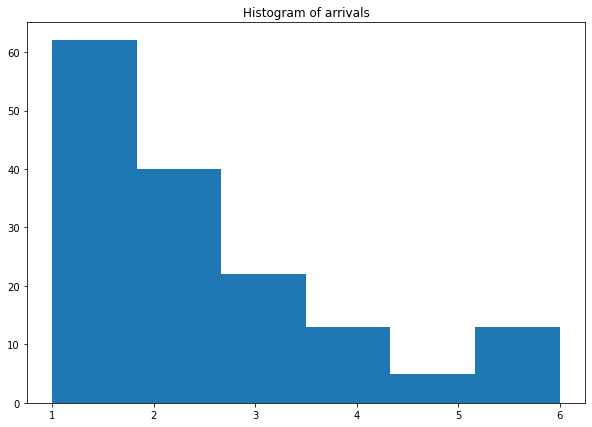

In [78]:
# round off arrivals
fig, ax = plt.subplots(figsize =(10, 7))
# mirror the arrivals to make it skewed for smaller arrivals compared to larger ones (can be removed if needed)
ax.hist([7-round(i) for i in arrival_rate],bins=6)
plt.title('Histogram of arrivals')